As part of the 2019.09 release we added a C++ implementation of the RDKit's similarity map functionality (https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-5-43). I forgot to mention this during the "What's New" bit of my presentation at the UGM, but I think it's worth calling attention to. So here's a quick blog post. 

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import numpy as np
import rdkit
print(rdkit.__version__)

2020.03.1


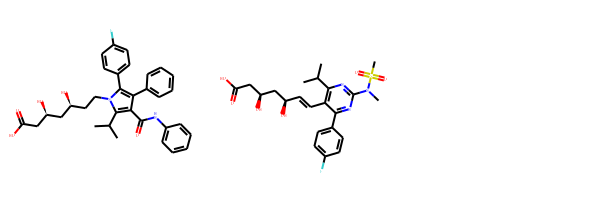

In [2]:
atorvastatin = Chem.MolFromSmiles('O=C(O)C[C@H](O)C[C@H](O)CCn2c(c(c(c2c1ccc(F)cc1)c3ccccc3)C(=O)Nc4ccccc4)C(C)C')
rosuvastatin = Chem.MolFromSmiles('OC(=O)C[C@H](O)C[C@H](O)\C=C\c1c(C(C)C)nc(N(C)S(=O)(=O)C)nc1c2ccc(F)cc2')
Draw.MolsToGridImage((atorvastatin,rosuvastatin))

I start by using "classic" similarity map functionality to show why atorvastatin (Lipitor) and rosuvastatin (Crestor) are similar to each other when using the Morgan fingerprint.
Here are the two molecules:

To use the new drawing code, we create a Draw2D object and pass that to SimilarityMaps.GetSimilarityMapForFingerprint: 

We can do the same thing with count-based fingerprints:

In [ ]:
d = Draw.MolDraw2DSVG(100, 100)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(atorvastatin, rosuvastatin, 
                                        lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

In [ ]:
d = Draw.MolDraw2DSVG(100, 100)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(atorvastatin, rosuvastatin, 
                                        lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='count'), 
                                        draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

The other GetSimilarityMapFrom... functions also accept the optional draw2d argument. Here's a visualization of the contributions made by the atoms in atorvastatin to its calculatied logp value: 

In [ ]:
from rdkit.Chem import rdMolDescriptors
ator_contribs = rdMolDescriptors._CalcCrippenContribs(atorvastatin)
d = Draw.MolDraw2DSVG(100, 100)
SimilarityMaps.GetSimilarityMapFromWeights(atorvastatin,[x[0] for x in ator_contribs],draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

And a couple more visualizations of various partial charge schemes.
Starting with Gasteiger-Marsilli charges:

In [ ]:
from rdkit.Chem import rdPartialCharges
rdPartialCharges.ComputeGasteigerCharges(atorvastatin)
chgs = [x.GetDoubleProp("_GasteigerCharge") for x in atorvastatin.GetAtoms()]
d = Draw.MolDraw2DSVG(100, 100)
SimilarityMaps.GetSimilarityMapFromWeights(atorvastatin,chgs,draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

And also the partial charges calculated with extended Hueckel theory (eHT) using Mulliken analysis:

In [ ]:
from rdkit.Chem import rdEHTTools
from rdkit.Chem import rdDistGeom
mh = Chem.AddHs(atorvastatin)
rdDistGeom.EmbedMolecule(mh)
_,res = rdEHTTools.RunMol(mh)
static_chgs = res.GetAtomicCharges()[:atorvastatin.GetNumAtoms()]
d = Draw.MolDraw2DSVG(100, 100)
SimilarityMaps.GetSimilarityMapFromWeights(atorvastatin,list(static_chgs),draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

As one final demo, I'll use the method to visualize the variability of the eHT charges with conformation for atorvastatin.
Start by generating 10 diverse conformers, calculating the charges for each, and plotting the average:

In [ ]:
mh = Chem.AddHs(atorvastatin)
ps = rdDistGeom.ETKDGv2()
ps.pruneRmsThresh = 0.5
ps.randomSeed = 0xf00d
rdDistGeom.EmbedMultipleConfs(mh,10,ps)
print(f'Found {mh.GetNumConformers()} conformers')
chgs = []
for conf in mh.GetConformers():
    _,res = rdEHTTools.RunMol(mh,confId=conf.GetId())
    chgs.append(res.GetAtomicCharges()[:atorvastatin.GetNumAtoms()])
chgs = np.array(chgs)
mean_chgs = np.mean(chgs,axis=0)
std_chgs = np.std(chgs,axis=0)
d = Draw.MolDraw2DSVG(100, 100)
SimilarityMaps.GetSimilarityMapFromWeights(atorvastatin,list(mean_chgs),draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

That doesn't look hugely different from what we saw above.
To show the variability, plot the standard deviation of the charges across the 10 conformers:

In [ ]:
print(std_chgs)
print(max(std_chgs),min(std_chgs))
d = Draw.MolDraw2DSVG(100, 100)
SimilarityMaps.GetSimilarityMapFromWeights(atorvastatin,list(std_chgs),draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

The deviations aren't huge (the printed array shows that), but the largest value is clearly the amide N. 

There's definitely a ToDo here to improve the way the negative contours are drawn so that the fact that they are being drawn with dashed lines is visible.